Dataset Exploratory Data Analysis
---
## Contents
* 1. Introduction
* 2. FGADR
* 3. IDRiD
* 4. Combined
---

## 1 Introduction

In this notebook, we examine the properties of three datasets: [FGADR](https://csyizhou.github.io/FGADR/), [IDRiD](https://idrid.grand-challenge.org/), 
<!-- TODO(sonjoonho): E-optha? -->

In [54]:
"""Notebook constants; replace these with your own."""

# Path to the root of this project.
PROJECT_DIR = "/vol/bitbucket/js6317/individual-project/semantic-dr-gan/"

# Seed for RNG.
SEED = 101

In [55]:
"""Load imports."""
import os
import sys
from pathlib import Path
from typing import List, Tuple

import cv2
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib.axes import Axes
from PIL import Image
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms as T

# Configure matplotlib.
plt.rcParams.update({"font.size": 15})
plt.style.use("seaborn-white")

In [56]:
"""Add `src/` to our path so that we can import functions from our codebase."""
sys.path.append(PROJECT_DIR)

from src.data.common import get_label_semantics
from src.data.datasets.combined import CombinedDataset
from src.utils.device import get_device
from src.utils.sample import colour_labels, colour_labels_numpy
from src.utils.seed import set_seed

set_seed(SEED)

## 2. FGADR

The Fine-Grained Annotated Diabetic Retinopathy (FGADR) dataset was released in 2020 alongside DR-GAN. It also consists of two subsets. The first, called the *Seg-set*, contains 1842 images with both image-level annotations, and pixel-level annotations for microaneurysms, haemorrhages, hard exudates, soft exudates, intra-retinal microvascular abnormalities, and neovascularization. Note that DR grades for images in the *Seg-set* are inferred. The second, called the *Grade-set*, contains 1000 images with only image-level annotations. We will not be exploring this dataset. Each image has a resolution of $1280 \times 1280$.

In [57]:
def filter_dataset_by_source(dataset: CombinedDataset, source: str) -> CombinedDataset:
    """This function modified the dataset in-place."""
    dataset.df = dataset.df[dataset.df["Source"] == source]
    return dataset


dataset = CombinedDataset(mode=CombinedDataset.ALL)
fgadr_dataset = filter_dataset_by_source(dataset, "FGADR")
fgadr_dataset.df.head()

,Grade,Image,Label,Instance,Source
0,2,/vol/vipdata/data/retina/FGADR-Seg/Seg-set/Ori...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,FGADR
1,3,/vol/vipdata/data/retina/FGADR-Seg/Seg-set/Ori...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,FGADR
2,2,/vol/vipdata/data/retina/FGADR-Seg/Seg-set/Ori...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,FGADR
3,4,/vol/vipdata/data/retina/FGADR-Seg/Seg-set/Ori...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,FGADR
4,2,/vol/vipdata/data/retina/FGADR-Seg/Seg-set/Ori...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,FGADR


Note that the sixth character in each filename appears to correspond to the annotator of a particular image. For example, `0000_1.png` will have been graded by "grader 1". This distinction between graders will become significant later.

The dataset contains retina fundus images. For each type of lesion, the dataset provides human-annotated, pixel-level segmentation masks.

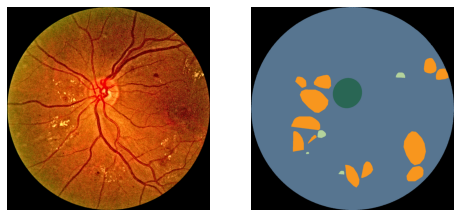

In [58]:
"""Plots a single sample from the FGADR dataset."""


def colour_pil_label(label: Image.Image) -> np.ndarray:
    label = np.array(label, dtype=int)
    label[label == 255] = 8
    coloured_label = colour_labels_numpy(label, reverse_channels=False).astype(int)

    return coloured_label


def plot_single_sample(dataset: CombinedDataset, n: int = 0):
    """Plots a single sample from `dataset`. Expects `dataset` to return PIL images."""
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

    sample = dataset[n]
    image, label = sample["image"], sample["label"]

    coloured_label = colour_pil_label(label)

    axs[0].imshow(image)
    axs[0].axis("off")

    axs[1].imshow(coloured_label)
    axs[1].axis("off")


plot_single_sample(fgadr_dataset, n=200)

By sampling image from each grade, we can quite clearly see a visual relationship between the prevalence of lesions and DR grade.

In [59]:
"""Plots a sample of images for each grade."""


def image_grid(array: np.array, ncols: int):
    """Returns images in `array` in a grid.

    Adapted from https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy.
    """
    nindex, height, width, intensity = array.shape
    nrows = nindex // ncols
    assert nindex == nrows * ncols
    # Swap axes to stack images column-wise.
#     result = array.reshape(nrows, ncols, height, width, intensity).swapaxes(0, 1)
    result = array.reshape(nrows, ncols, height, width, intensity)
    result = result.swapaxes(1, 2).reshape(height * nrows, width * ncols, intensity)

    return result


def get_samples_per_grade(dataset: CombinedDataset, n_samples=5) -> Tuple[np.ndarray, np.ndarray]:

    grade_groups = dataset.df.groupby(by="Grade")
    grade_samples = grade_groups.sample(n_samples, replace=True)

    images = []
    labels = []
    for i, (grade, image_path, label_path, _, _) in enumerate(grade_samples.values):
        label = Image.open(label_path)
        label = colour_pil_label(label)

        image = Image.open(image_path)
        image = np.array(image)

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)


images, labels = get_samples_per_grade(fgadr_dataset)

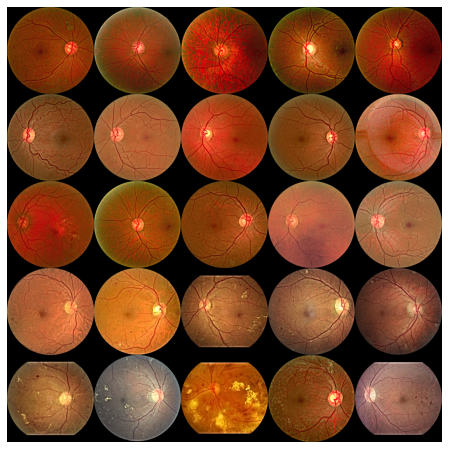

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis("off")
ax.set_aspect("equal")

gallery = image_grid(np.array(images), 5)
ax.imshow(gallery)
plt.savefig("figs/fgadr_real_sample.pdf", dpi=200)
plt.show()

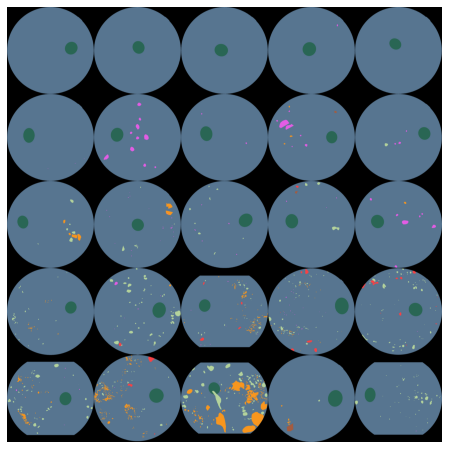

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis("off")
ax.set_aspect("equal")

gallery = image_grid(np.array(labels), 5)
ax.imshow(gallery)
plt.savefig("figs/fgadr_label_sample.pdf", dpi=200)
plt.show()

From looking at the proportions of each grade, we can see that grades 2 and 3 are overrepresented, while grades 0, 1, and 4 are underrepresented.

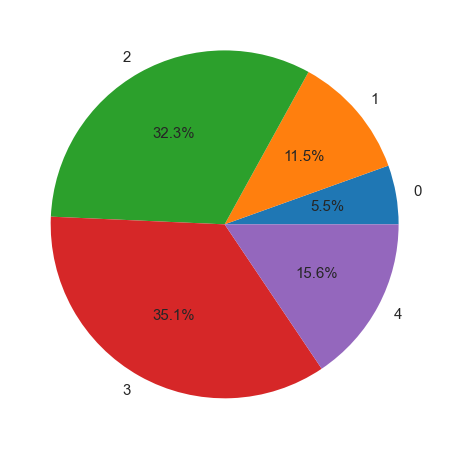

In [62]:
def plot_grade_piechart(df: pd.DataFrame, title: str, ax: Axes = None) -> Axes:
    grade_groups = df.groupby(by="Grade")
    grade_counts = grade_groups.count()
    ax = grade_counts.plot(kind="pie", y="Image", title=title, autopct="%1.1f%%", ax=ax)
    ax.axis("off")
    ax.get_legend().remove()
    return ax


fig, ax = plt.subplots(figsize=(8, 8))
plot_grade_piechart(fgadr_dataset.df, "", ax=ax)
plt.savefig("figs/fgadr_seg_grade_dist.pdf")
plt.show()

We can see that grader 1 labels very coarsely, in a way which is inconsistent with the other graders. Since these labels need to represent segmentation masks, we can't use them. They all seem to fall under "1", but not able to distinguish these.


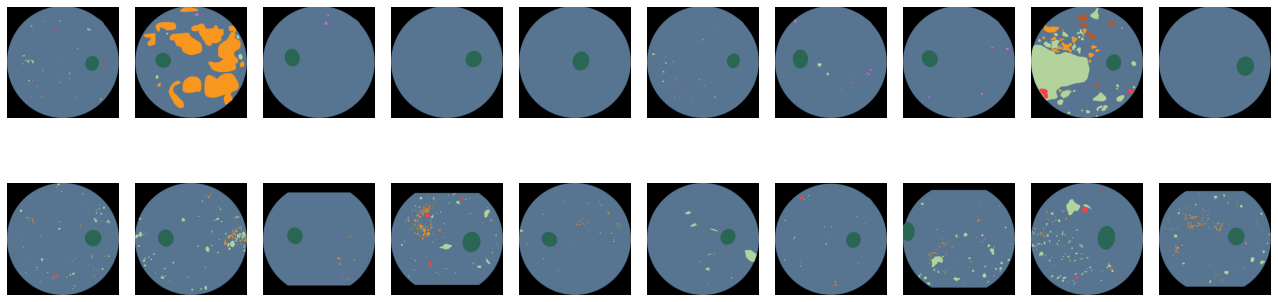

In [63]:
"""Samples `n_samples` images to compare those annotated by grader 1, and those not annotated by grader 1."""

fgadr_dataset.df["Grader"] = pd.to_numeric(fgadr_dataset.df["Image"].str[-5])
grader_1_cond = fgadr_dataset.df["Grader"] == 1
not_grader_1_cond = fgadr_dataset.df["Grader"] != 1


def plot_grader_annotations(grader_sample, axs):
    for i, (_, _, label, _, _, _) in enumerate(grader_sample.values):
        ax = axs[i]

        label = Image.open(label)
        coloured_label = colour_pil_label(label)

        ax.axis("off")
        ax.imshow(coloured_label)


def plot_grader_1_vs_others(dataset: CombinedDataset):
    n_samples = 10

    df = dataset.df

    grader_1_sample = df.loc[grader_1_cond].sample(n_samples)
    not_grader_1_sample = df.loc[not_grader_1_cond].sample(n_samples)

    fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(18, 6))

    plot_grader_annotations(grader_1_sample, axs[0])
    plot_grader_annotations(not_grader_1_sample, axs[1])

    fig.tight_layout()


plot_grader_1_vs_others(fgadr_dataset)
plt.show()

The first thought is to just exclude these. However, this severely effects the grade distribution. This is offset by adding the IDRiD dataset (not really).

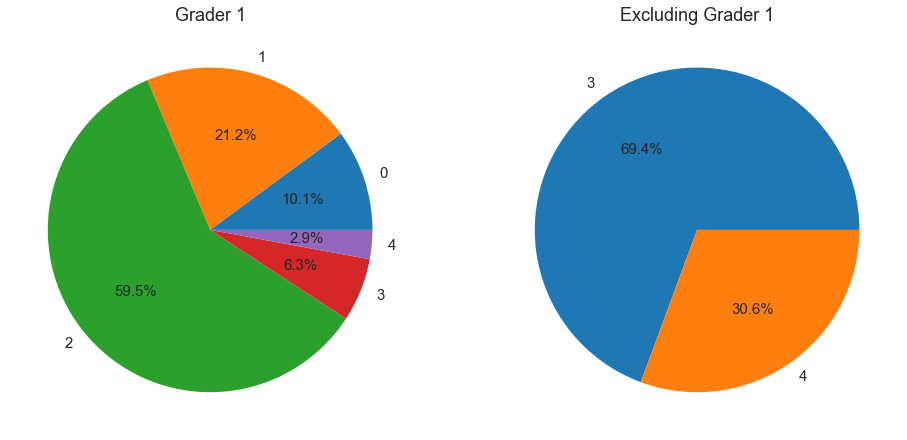

In [64]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

ax1 = plot_grade_piechart(fgadr_dataset.df.loc[grader_1_cond], "Grader 1", ax=axs[0])
ax2 = plot_grade_piechart(fgadr_dataset.df.loc[not_grader_1_cond], "Excluding Grader 1", ax=axs[1])

plt.show()

In [65]:
def plot_fgadr_files(filenames: List[str]):
    n_files = len(filenames)
    n_counts = len(filenames)
    fig, axs = plt.subplots(nrows=n_files // 2, ncols=n_files // 2, figsize=(8, 8))
    for i, fn in enumerate(filenames):
        row = i % (n_counts // 2)
        col = i // (n_files // 2)
        path = fgadr_dataset.df.loc[fgadr_dataset.df["Label"].str.contains(fn)].iloc[0]["Label"]
        image = Image.open(path)
        ax = axs[row][col]
        ax.imshow(colour_pil_label(image))
        ax.set_title(fn + ".png")
        ax.axis("off")

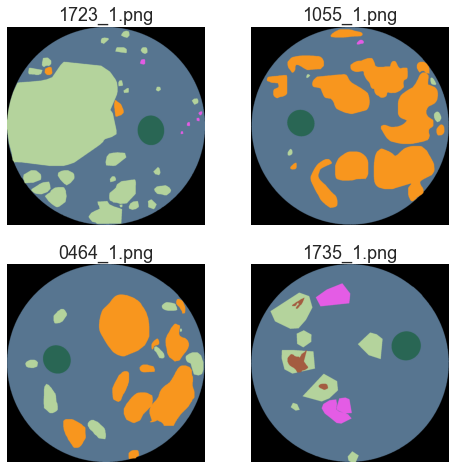

In [66]:
bad_files = ["1723_1", "0464_1", "1055_1", "1735_1"]

plot_fgadr_files(bad_files)
plt.savefig("figs/fgadr_bad_sample.pdf", dpi=200)
plt.show()

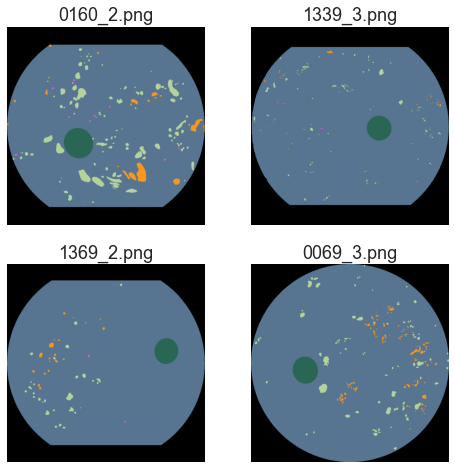

In [67]:
good_files = ["0160_2", "1369_2", "1339_3", "0069_3"]

plot_fgadr_files(good_files)
plt.savefig("figs/fgadr_good_sample.pdf", dpi=200)
plt.show()

In [68]:
"""Plots the number of images with the specified lesions."""

transform = T.Compose([T.ToTensor()])
dataset = CombinedDataset(mode=CombinedDataset.ALL, return_image=False, label_transform=transform)
fgadr_dataset = filter_dataset_by_source(dataset, "FGADR")


classes = {"MA": 2, "HE": 3, "EX": 4, "SE": 5, "NV": 6, "IRMA": 7}


class_colours = (
    np.asarray(
        [
            [228, 92, 229],  # MA
            [180, 211, 156],  # HE
            [248, 150, 30],  # EX
            [249, 65, 68],  # SE
            [250, 208, 44],  # NV
            [164, 92, 64],  # IRMA
        ]
    )
    / 255.0
)

In [69]:
def calculate_lesion_counts(dataset: CombinedDataset):
    dataloader = DataLoader(dataset, batch_size=64)
    counts = {
        "MA": 0,
        "HE": 0,
        "EX": 0,
        "SE": 0,
        "NV": 0,
        "IRMA": 0,
    }

    for batch in dataloader:
        labels = batch["label"]
        labels = get_label_semantics(labels)
        labels = labels.view(labels.shape[0], labels.shape[1], -1)
        for k, v in classes.items():
            count = torch.count_nonzero(labels[:, v, :], dim=1)
            count = torch.where(count > 0, 1, 0)
            counts[k] += torch.sum(count).item()

    return counts


counts = calculate_lesion_counts(fgadr_dataset)

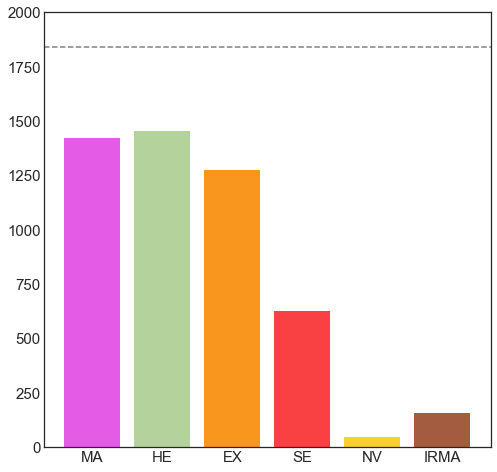

In [70]:
def plot_lesion_prevalance(counts):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_ylim(0, 2000)
    ax.axhline(len(fgadr_dataset), linestyle="--", color="gray")
    ax.bar(counts.keys(), counts.values(), color=class_colours)


plot_lesion_prevalance(counts)
plt.show()

## IDRiD
---

Analysis is more limited since there are no labels for these images. Note that the disease grading set is mutually exclusive with the segmentation set. This can be confirmed by running some script. We have no access to grader information, but it seems quite consistent.

In [71]:
dataset = CombinedDataset(mode=CombinedDataset.ALL)
idrid_dataset = filter_dataset_by_source(dataset, "IDRiD")
idrid_dataset.df.head()

,Grade,Image,Label,Instance,Source
0,3,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,IDRiD
1,3,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,IDRiD
2,3,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,IDRiD
3,4,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,IDRiD
4,4,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,IDRiD


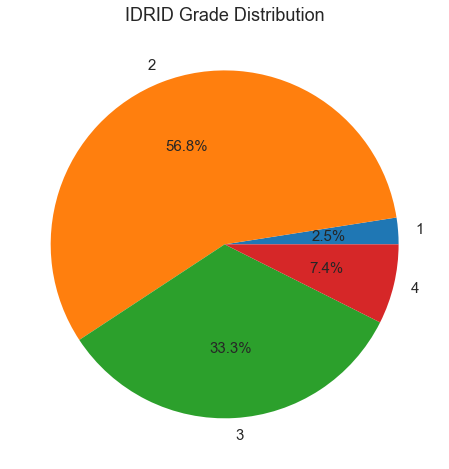

In [72]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_grade_piechart(idrid_dataset.df, "IDRID Grade Distribution", ax=ax)
plt.savefig("figs/idrid_grade_dist.pdf")
plt.show()

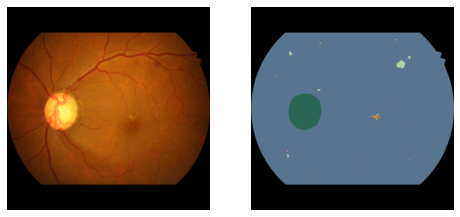

In [73]:
plot_single_sample(idrid_dataset, n=11)

In [74]:
images, labels = get_samples_per_grade(idrid_dataset)
print(images.shape)

(20, 1280, 1280, 3)


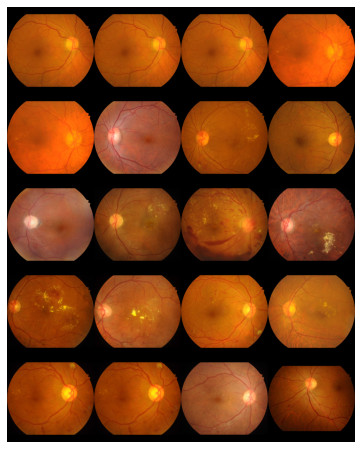

In [75]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis("off")
# ax.set_aspect("equal")

gallery = image_grid(np.array(images), 4)
ax.imshow(gallery)
plt.savefig("figs/idrid_real_sample.pdf", dpi=200)
plt.show()

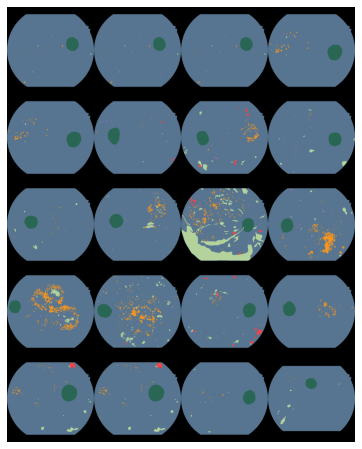

In [76]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis("off")
# ax.set_aspect("equal")

gallery = image_grid(np.array(labels), 4)
ax.imshow(gallery)
plt.savefig("figs/idrid_label_sample.pdf", dpi=200)
plt.show()

## DIARETDB1


In [77]:
dataset = CombinedDataset(mode=CombinedDataset.ALL)
diaretdb1_dataset = filter_dataset_by_source(dataset, "DIARETDB1")
diaretdb1_dataset.df.head()

,Grade,Image,Label,Instance,Source
0,4,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,DIARETDB1
1,4,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,DIARETDB1
2,4,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,DIARETDB1
3,4,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,DIARETDB1
4,4,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,/vol/bitbucket/js6317/individual-project/seman...,DIARETDB1


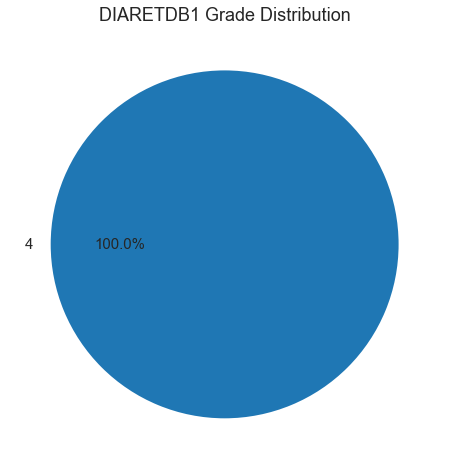

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_grade_piechart(diaretdb1_dataset.df, "DIARETDB1 Grade Distribution", ax=ax)
plt.savefig("figs/diaretdb1_grade_dist.pdf")
plt.show()

In [79]:
images, labels = get_samples_per_grade(diaretdb1_dataset)

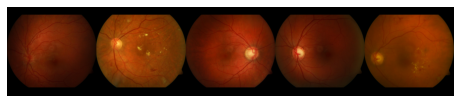

In [80]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis("off")
ax.set_aspect("equal")

gallery = image_grid(np.array(images), 5)
ax.imshow(gallery)
plt.savefig("figs/diaretdb1_real_sample.pdf", dpi=200)
plt.show()

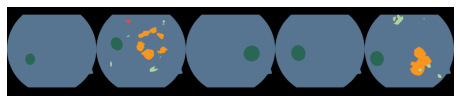

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis("off")
ax.set_aspect("equal")

gallery = image_grid(np.array(labels), 5)
ax.imshow(gallery)
plt.savefig("figs/diaretdb1_label_sample.pdf", dpi=200)
plt.show()

## Total 

In [ ]:
dataset = CombinedDataset()
plot_grade_piechart(dataset.df, "Grader 1")
plt.show()

In [ ]:
# Custom Visualizations

# Compare with/without grader 1?
transform = T.Compose([T.ToTensor()])
dataset = CombinedDataset(return_image=False, common_transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

device = get_device()

batch = next(iter(dataloader))
X = batch["label"]
y = batch["grade"]

X = get_label_semantics(X)[:, [2, 3, 4, 5], :, :]
X = X.to(device)
y = y.to(device)

# Plot relationship between lesion area and grade
c = torch.sum(X, dim=[1, 2, 3])

data = np.vstack((c.cpu().numpy(), y.cpu().numpy()))

lesion_area_df = pd.DataFrame(data.T, columns=["Area", "Grade"])

In [ ]:
groups = lesion_area_df.boxplot(by="Grade")
plt.show()

In [ ]:
"""Samples `n_samples` images to compare those annotated by grader 1, and those not annotated by grader 1."""

fgadr_dataset.df["Grader"] = pd.to_numeric(fgadr_dataset.df["Image"].str[-5])
grader_1_cond = fgadr_dataset.df["Grader"] == 1
not_grader_1_cond = fgadr_dataset.df["Grader"] != 1


def plot_grader_1_vs_others(dataset: CombinedDataset):
    n_samples = 75

    df = dataset.df

    grader_1_sample = df.loc[grader_1_cond].sample(n_samples)

    n_cols = 15
    n_rows = n_samples // n_cols
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8))

    for i, (_, _, label_path, _, _, _) in enumerate(grader_1_sample.values):
        col = i % n_cols
        row = i // n_cols
        ax = axs[row][col]

        label = Image.open(label_path)
        coloured_label = colour_pil_label(label)

        ax.axis("off")
        ax.imshow(coloured_label)
        ax.set_title(label_path[-10::], fontdict={"fontSize": 10})
    fig.tight_layout()


plot_grader_1_vs_others(fgadr_dataset)
plt.show()

## EyePACS

In [ ]:
from src.data.datasets.eyepacs import EyePACS

train_dataset = EyePACS(train=True)

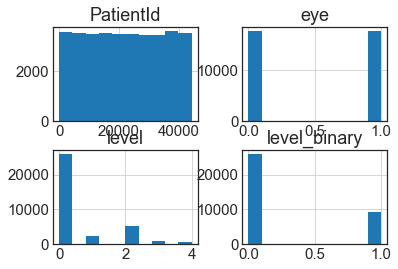

In [98]:
df = train_dataset.df
df.hist()
plt.show()

NameError: name 'train_dataset' is not defined

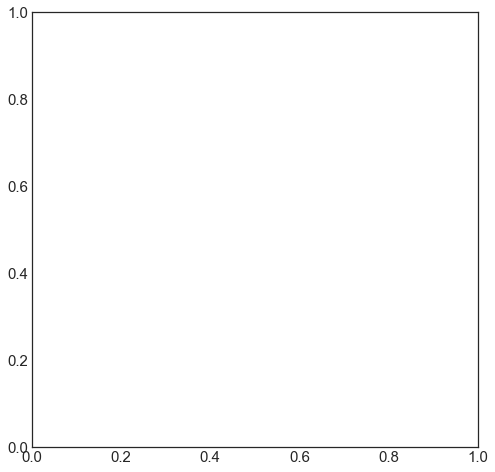

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

grade_groups = train_dataset.df.groupby(by="level")
grade_counts = grade_groups.count()
grade_counts.plot(kind="pie", y="name", autopct="%1.1f%%", ax=ax)
ax.axis("off")
ax.get_legend().remove()
plt.savefig("eyepacs_grade_dist.pdf")
plt.show()

In [13]:
def load_model(path: Path, n_classes: int) -> nn.Module:
    model = models.resnet50()
    fc_n_features = model.fc.in_features
    model.fc = nn.Linear(fc_n_features, n_classes)
    model.load_state_dict(torch.load(path))
    model.eval()

    return model


path = Path(
    "/vol/bitbucket/js6317/individual-project/semantic-dr-gan/results/resnet/fgadr_images/checkpoints/model_latest.pth"
)
model = load_model(path, 5)
model.cuda();

In [16]:
from torchvision.transforms import InterpolationMode

img_size = 256

transform = T.Compose([T.Resize(img_size, interpolation=InterpolationMode.NEAREST), T.ToTensor()])
train_dataset = CombinedDataset(common_transform=transform, return_image=False)
train_dataset.df = train_dataset.df[train_dataset.df["Source"] == "FGADR"]

dataloader = DataLoader(train_dataset, batch_size=32, num_workers=0, pin_memory=True, shuffle=False, drop_last=True)

In [21]:
def get_feature_vector(model, x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    return x


features = []
grades = []
filenames = []
for batch in dataloader:
    labels = batch["label"]
    labels = get_label_semantics(labels)
    labels = colour_labels(labels)
    labels = labels.cuda()
    features.append(get_feature_vector(model, labels).detach().cpu().numpy())
    grades.append(batch["grade"].detach().cpu().numpy())
    filenames += list(batch["filename"])
features = np.array(features)
features = features.reshape(features.shape[0] * features.shape[1], -1)
grades = np.array(grades)
grades = grades.reshape(grades.shape[0] * grades.shape[1])

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=SEED, perplexity=50).fit_transform(features)

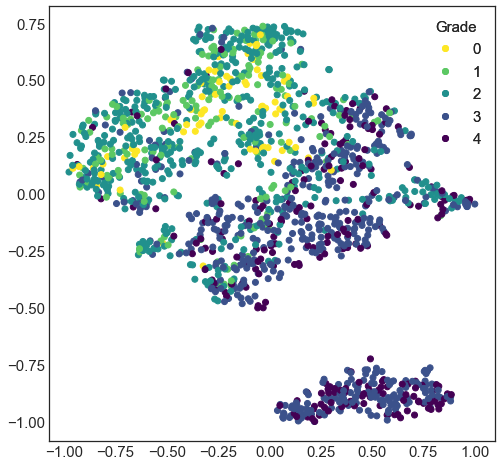

In [49]:
import random
fig, ax = plt.subplots(figsize=(8, 8))

# Normalise each component.
component1 = tsne[:, 0] / np.max(np.abs(tsne[:, 0]))
component2 = tsne[:, 1] / np.max(np.abs(tsne[:, 1]))
scatter = ax.scatter(component1, component2, c=grades, cmap="viridis_r")
# for i, txt in enumerate(filenames):
#     if random.random() < 0.2:
#         ax.annotate(txt, (component1[i], component2[i]), color="red", size="small")
    
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Grade")
ax.add_artist(legend1)
plt.savefig("figs/fgadr_label_tsne.pdf")
plt.show()

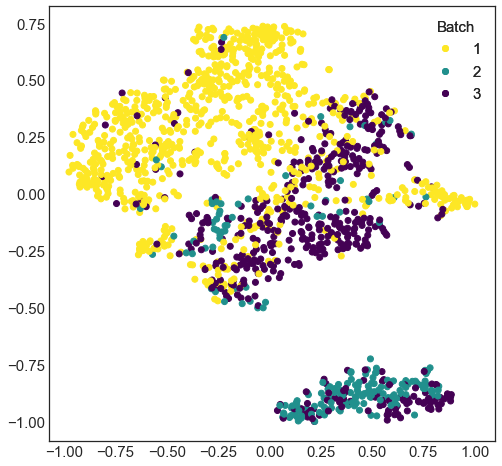

In [50]:
import random
fig, ax = plt.subplots(figsize=(8, 8))

graders = [int(x[5]) for x in filenames]

# Normalise each component.
component1 = tsne[:, 0] / np.max(np.abs(tsne[:, 0]))
component2 = tsne[:, 1] / np.max(np.abs(tsne[:, 1]))
scatter = ax.scatter(component1, component2, c=graders, cmap="viridis_r")
# for i, txt in enumerate(filenames):
#     if random.random() < 0.2:
#         ax.annotate(txt, (component1[i], component2[i]), color="red", size="small")
    
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Batch")
ax.add_artist(legend1)
plt.savefig("figs/fgadr_batch_tsne.pdf")
plt.show()